In [ ]:
import os
import pandas as pd
from random import choice
import shutil

In [ ]:
imgs =[]
train_imgs = []
test_imgs = []

trainPath = 'workspace/training/images/train'
testPath = 'workspace/training/images/test'
crsPath = 'workspace/training/images'

train_ratio = 0.9
test_ratio = 0.1

%mkdir workspace/training/images/train
%mkdir workspace/training/images/test

for (dirname, dirs, files) in os.walk(crsPath):
    for filename in files:
        if filename.endswith('.jpg'):
            imgs.append(filename)

totalImgCount = len(imgs)

countForTrain = int(len(imgs)*train_ratio)
countForTest = int(len(imgs) - countForTrain)

for x in range(countForTrain):

    fileJpg = choice(imgs)

    shutil.copy(os.path.join(crsPath, fileJpg), os.path.join(trainPath, fileJpg))

    imgs.remove(fileJpg)
    train_imgs.append(fileJpg)

for x in range(countForTest):

    fileJpg = choice(imgs)

    shutil.copy(os.path.join(crsPath, fileJpg), os.path.join(testPath, fileJpg))

    imgs.remove(fileJpg)
    test_imgs.append(fileJpg)

print('Total images: ', totalImgCount)
print('Images in train dir:', len(os.listdir(trainPath)))
print('Images in test dir:', len(os.listdir(testPath)))

Total images:  36
Images in train dir: 32
Images in test dir: 4


In [ ]:
annotations = pd.read_csv('workspace/training/annotations/annotations.csv')

annotations[annotations.filename.isin(train_imgs)].to_csv('workspace/training/annotations/train_annotations.csv', index=None)
annotations[annotations.filename.isin(test_imgs)].to_csv('workspace/training/annotations/test_annotations.csv', index=None)

In [ ]:
!python workspace/generate_tfrecord.py --csv_input=workspace/training/annotations/train_annotations.csv  --image_dir=workspace/training/images/train --output_path=workspace/training/annotations/train.record
!python workspace/generate_tfrecord.py --csv_input=workspace/training/annotations/test_annotations.csv  --image_dir=workspace/training/images/test --output_path=workspace/training/annotations/test.record

In [ ]:
!protoc object_detection/protos/*.proto --python_out=.

In [ ]:
!cd /content/workspace/training/

In [ ]:
!python model_main.py --alsologtostderr --model_dir=./ --pipeline_config_path=faster_rcnn_inception_v2_coco.config

### Inference

In [ ]:
!cd /content/models/research

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

model_path = 'workspace/training/waldo_inference_graph/frozen_inference_graph.pb'

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(model_path, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

label_map = label_map_util.load_labelmap('workspace/training/annotations/label_map.pbtxt')
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=1, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

Wally found


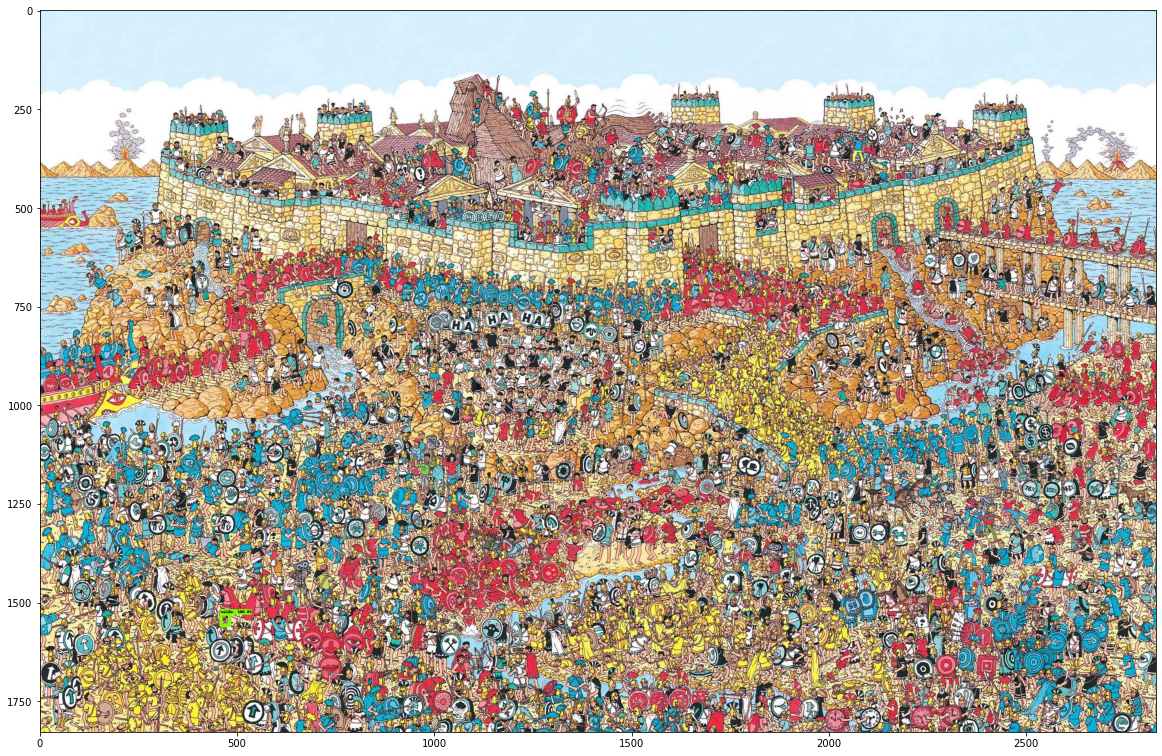

In [ ]:
%matplotlib inline
image_path = 'deep_learning_test.jpg'
with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    image_np = load_image_into_numpy_array(Image.open(image_path))
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    scores = detection_graph.get_tensor_by_name('detection_scores:0')
    classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    # Actual detection.
    (boxes, scores, classes, num_detections) = sess.run(
        [boxes, scores, classes, num_detections],
        feed_dict={image_tensor: np.expand_dims(image_np, axis=0)})

    if scores[0][0] < 0.1:
        print('Wally not found :(')
        print(boxes)


    print('Wally found')
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        np.squeeze(boxes),
        np.squeeze(classes).astype(np.int32),
        np.squeeze(scores),
        category_index,
        use_normalized_coordinates=True,
        line_thickness=8,
        min_score_thresh = 0.2)
    plt.figure(figsize=(20, 20))
    plt.imshow(image_np)
    plt.show()